In [1]:
#Initial configuration, probably overkill in imports.
import sys, os, re
import numpy as np
import pandas as pd
import allel
import zarr
import dask
import numcodecs
import warnings
from pathlib import Path


%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from horizonplot import horizonplot
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("notebook")

#Dask setup
from multiprocessing.pool import ThreadPool
import dask
dask.config.set(pool=ThreadPool(int(os.environ['SLURM_CPUS_PER_TASK'])))

In [2]:
#Opening the zarr data
callset = zarr.open_group('/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/callset.zarr', mode='r')
callset.tree(expand=False)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='chr1', nodes=(Node(disabled=True, n…

In [3]:
chromosomes = [f'chr{x}' for x in range(1, 21)] + ['chrX']
meta_data = pd.read_excel('../data/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')
baboon_samples = [x for x in meta_data.PGDP_ID if x.startswith('PD')] #  NB: to not get the SciAdvPaper samples
#Meta data for the sample present in the zarr data structure - Kasper has removed some of the samples.
samples_list = list(callset['chr1/samples'][:])
meta_data_samples = meta_data.loc[meta_data.PGDP_ID.isin(samples_list)].copy()
samples_callset_index = [samples_list.index(s) for s in meta_data_samples.PGDP_ID]
meta_data_samples['callset_index'] = samples_callset_index

In [4]:
meta_data_samples.to_csv("../data/meta_data_samples.txt", sep = " ", index=False)
meta_data_samples

Unnamed: 0  PGDP_ID    Provider_ID                      Provider  Genus  \
1             1  PD_0199   09SNF1101115              Knauf/Chuma/Roos  Papio   
2             2  PD_0200   11SNF1101115              Knauf/Chuma/Roos  Papio   
3             3  PD_0201   19SNM1131115              Knauf/Chuma/Roos  Papio   
4             4  PD_0202   20SNF1131115              Knauf/Chuma/Roos  Papio   
5             5  PD_0203   21SNF1151115              Knauf/Chuma/Roos  Papio   
..          ...      ...            ...                           ...    ...   
212         212  PD_0789  34417_BZ11064  Rogers/Jolly/Phillips-Conroy  Papio   
213         213  PD_0790  34418_BZ11065  Rogers/Jolly/Phillips-Conroy  Papio   
214         214  PD_0791  34419_BZ11066  Rogers/Jolly/Phillips-Conroy  Papio   
215         215  PD_0792  34420_BZ11067  Rogers/Jolly/Phillips-Conroy  Papio   
216         216  PD_0793  34422_BZ11070  Rogers/Jolly/Phillips-Conroy  Papio   

    Species               Origin Sex  \
1    anubis  Serengeti, Tanzania   F   
2    anubis  Serengeti, Tanzania   F   
3    anubis  Serengeti, Tanzania   M   
4    anubis  Serengeti, Tanzania   F   
5    anubis  Serengeti, Tanzania   F   
..      ...                  ...  ..   
212  kindae       Chunga, Zambia   F   
213  kindae       Chunga, Zambia   F   
214  kindae       Chunga, Zambia   F   
215  kindae       Chunga, Zambia   F   
216  kindae       Chunga, Zambia   M   

                                               address  longitude   latitude  \
1                 Serengeti, Mara, Lake Zone, Tanzania  34.742544  -1.996626   
2                 Serengeti, Mara, Lake Zone, Tanzania  34.742544  -1.996626   
3                 Serengeti, Mara, Lake Zone, Tanzania  34.742544  -1.996626   
4                 Serengeti, Mara, Lake Zone, Tanzania  34.742544  -1.996626   
5                 Serengeti, Mara, Lake Zone, Tanzania  34.742544  -1.996626   
..                                                 ...        ...        ...   
212  Chunga, Mumbwa District, Central Province, Zambia  26.005210 -15.053557   
213  Chunga, Mumbwa District, Central Province, Zambia  26.005210 -15.053557   
214  Chunga, Mumbwa District, Central Province, Zambia  26.005210 -15.053557   
215  Chunga, Mumbwa District, Central Province, Zambia  26.005210 -15.053557   
216  Chunga, Mumbwa District, Central Province, Zambia  26.005210 -15.053557   

     callset_index  
1                0  
2                1  
3                2  
4                3  
5                4  
..             ...  
212            155  
213            156  
214            157  
215            158  
216            159  

[160 rows x 12 columns]

In [5]:
#Opening the tables generated in heterozygosity_windows
het_counts_path = "../steps/het_counts_windows_{}.txt"
callability_percentage_path = "../steps/callability_windows_{}.txt"
het_list = []
call_list = []
for chrom in chromosomes:
    df = pd.read_table(het_counts_path.format(chrom), sep = " ")
    het_list.append(df)
    c_df = pd.read_table(callability_percentage_path.format(chrom), sep = " ")
    call_list.append(c_df)
het_df = pd.concat(het_list, axis=0)
call_df = pd.concat(call_list, axis=0)
#There are some columns with NaN, replacing those with 0
het_df["het"] = het_df["het"].fillna(0)
#Renaming columns to make horizonplot work
original_names = het_df.copy()
het_df.rename(columns = {"window": "start", "chr": "chrom", "PGDP_ID": "pop"}, inplace=True)

#call_df = pd.concat(call_list, axis=0)

In [6]:
call_df

chr  window  PGDP_ID  coverage
0       chr1       0  PD_0199   0.80327
1       chr1       1  PD_0199   0.91796
2       chr1       2  PD_0199   0.70480
3       chr1       3  PD_0199   0.32129
4       chr1       4  PD_0199   0.58661
...      ...     ...      ...       ...
244635  chrX    1524  PD_0793   0.98557
244636  chrX    1525  PD_0793   0.60963
244637  chrX    1526  PD_0793   0.45368
244638  chrX    1527  PD_0793   0.95241
244639  chrX    1528  PD_0793   0.95385

[4596320 rows x 4 columns]

In [7]:
#Test subset of individuals
test_subset = meta_data_samples.take([0, 10, 144,])
test_subset

Unnamed: 0  PGDP_ID    Provider_ID                      Provider  Genus  \
1             1  PD_0199   09SNF1101115              Knauf/Chuma/Roos  Papio   
11           11  PD_0209   05NCF1150516              Knauf/Chuma/Roos  Papio   
201         201  PD_0778  34390_BZ11034  Rogers/Jolly/Phillips-Conroy  Papio   

    Species                Origin Sex  \
1    anubis   Serengeti, Tanzania   F   
11   anubis  Ngorongoro, Tanzania   F   
201  kindae        Chunga, Zambia   M   

                                               address  longitude   latitude  \
1                 Serengeti, Mara, Lake Zone, Tanzania  34.742544  -1.996626   
11         Ngorongoro, Arusha, Northern Zone, Tanzania  35.585946  -2.676953   
201  Chunga, Mumbwa District, Central Province, Zambia  26.005210 -15.053557   

     callset_index  
1                0  
11              10  
201            144

In [8]:
print(len(original_names), len(call_df)) #There is a small difference in number of windows.

4549120 4596320


In [9]:
#Check lengths for each chromosome/ID combination, and cutting off final parts if incongruent.
trimmed_het = []
trimmed_call = []
for chrom in chromosomes:
    chrom_df = original_names.loc[original_names.chr == chrom].copy()
    callability_df = call_df.loc[call_df.chr == chrom].copy()
    for i, row in meta_data_samples.iterrows():
        chrom_i = chrom_df.loc[chrom_df.PGDP_ID == row.PGDP_ID]
        call_i = callability_df.loc[callability_df.PGDP_ID == row.PGDP_ID]
        chrom_i["sex"] = row.Sex[:]
        chrom_i["species"] = row.Species[:]
        call_i["sex"] = row.Sex[:]
        call_i["species"] = row.Species[:]
        if len(chrom_i) > len(call_i):
            trimmed_het.append(chrom_i.iloc[:len(call_i)])
            trimmed_call.append(call_i)
        elif len(chrom_i) < len(call_i):
            trimmed_call.append(call_i.iloc[:len(chrom_i)])
            trimmed_het.append(chrom_i)
    print(chrom)
het_df_trimmed = pd.concat(trimmed_het, axis=0)
call_df_trimmed = pd.concat(trimmed_call, axis=0)
call_df_trimmed.loc[call_df_trimmed.coverage == 0, "coverage"] = 1

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWar

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX


In [10]:
print(len(het_df_trimmed), len(call_df_trimmed))
#call_df_trimmed.loc[call_df_trimmed.coverage == 0]

4535040 4535040


In [11]:
het_df_trimmed["het_c"] = het_df_trimmed["het"].values/call_df_trimmed["coverage"].values
het_df_trimmed.rename(columns = {"window": "start", "chr": "chrom", "PGDP_ID": "pop"}, inplace=True)

In [12]:
het_df_trimmed

chrom  start      pop     het sex species        het_c
0       chr1      0  PD_0199   337.0   F  anubis   419.535150
1       chr1      1  PD_0199   168.0   F  anubis   183.014510
2       chr1      2  PD_0199    90.0   F  anubis   127.695800
3       chr1      3  PD_0199   379.0   F  anubis  1179.619658
4       chr1      4  PD_0199   127.0   F  anubis   216.498184
...      ...    ...      ...     ...  ..     ...          ...
245430  chrX   1524  PD_0793   268.0   M  kindae   271.923861
245431  chrX   1525  PD_0793  1002.0   M  kindae  1643.619901
245432  chrX   1526  PD_0793   302.0   M  kindae   665.667431
245433  chrX   1527  PD_0793   874.0   M  kindae   917.672011
245434  chrX   1528  PD_0793  1057.0   M  kindae  1108.141174

[4535040 rows x 7 columns]

In [13]:
##Checking Na
#het_df["het"].isna().sum() # 36800 Na before removal, out of
#len(het_df) # 4549120 columns

In [14]:
print(len(call_df.loc[call_df.coverage == 0]))
print(len(het_df.loc[het_df.het == 0])) #More windows without heterozygosity than 0 coverage.

98144
210640


In [15]:
#Subsetting to chrX and chr7 (similar in size)
#Using trimmed version now
x_df = het_df_trimmed.loc[het_df_trimmed.chrom == "chrX"]
x_call = call_df_trimmed.loc[call_df_trimmed.chr == "chrX"]
chr7_df = het_df_trimmed.loc[het_df_trimmed.chrom == "chr7"]
chr7_df

chrom  start      pop    het sex species        het_c
0       chr7      0  PD_0199   50.0   F  anubis   567.536890
1       chr7      1  PD_0199   56.0   F  anubis   345.210208
2       chr7      2  PD_0199   35.0   F  anubis   185.725657
3       chr7      3  PD_0199   29.0   F  anubis    49.259410
4       chr7      4  PD_0199   99.0   F  anubis   146.618880
...      ...    ...      ...    ...  ..     ...          ...
271835  chr7   1694  PD_0793  112.0   M  kindae   900.900901
271836  chr7   1695  PD_0793  358.0   M  kindae  1136.977165
271837  chr7   1696  PD_0793  593.0   M  kindae   797.214455
271838  chr7   1697  PD_0793  671.0   M  kindae   749.528054
271839  chr7   1698  PD_0793  405.0   M  kindae   965.527106

[271840 rows x 7 columns]

In [16]:
x_call

chr  window  PGDP_ID  coverage sex species
0       chrX       0  PD_0199   0.36168   F  anubis
1       chrX       1  PD_0199   0.12722   F  anubis
2       chrX       2  PD_0199   1.00000   F  anubis
3       chrX       3  PD_0199   0.37461   F  anubis
4       chrX       4  PD_0199   0.32032   F  anubis
...      ...     ...      ...       ...  ..     ...
244635  chrX    1524  PD_0793   0.98557   M  kindae
244636  chrX    1525  PD_0793   0.60963   M  kindae
244637  chrX    1526  PD_0793   0.45368   M  kindae
244638  chrX    1527  PD_0793   0.95241   M  kindae
244639  chrX    1528  PD_0793   0.95385   M  kindae

[244640 rows x 6 columns]

In [17]:
#Male mean het and coverage on X
x_df = het_df_trimmed.loc[het_df_trimmed.chrom == "chrX"]
x_call = call_df_trimmed.loc[call_df_trimmed.chr == "chrX"]
x_df = x_df.loc[x_df.sex == "M"]
x_call = x_call.loc[x_call.sex == "M"]

het_list = []
coverage_list = []
window = []
max(x_df["start"])
for i in range(max(x_df["start"])):
    window.append(i)
    mean_het = x_df.loc[x_df.start == i]["het"].mean()
    het_list.append(mean_het)
    mean_coverage = x_call.loc[x_call.window == i]["coverage"].mean()
    coverage_list.append(mean_coverage)
d_male = {"window": window, "mean_het": het_list, "mean_coverage": coverage_list}
mean_df_male = pd.DataFrame(data = d_male)

<AxesSubplot:xlabel='window', ylabel='mean_het'>

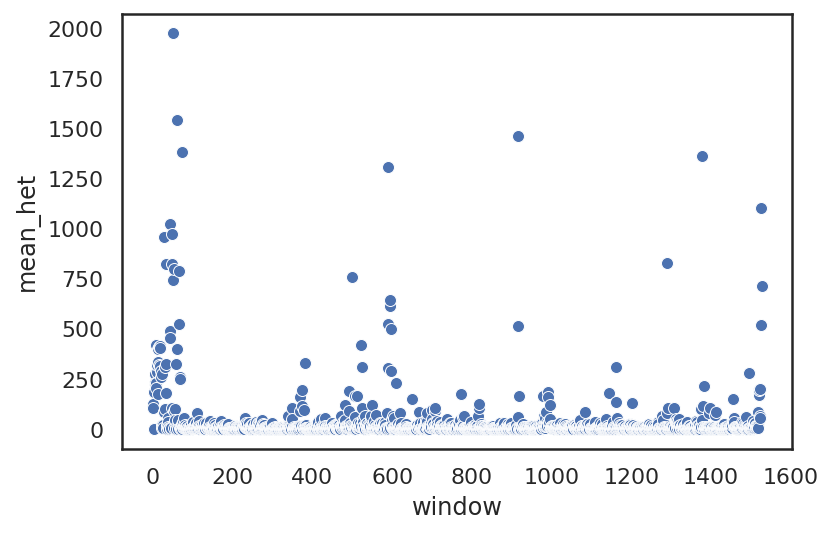

In [18]:
sns.scatterplot(data = mean_df_male, x = "window", y = "mean_het")

<AxesSubplot:xlabel='window', ylabel='mean_coverage'>

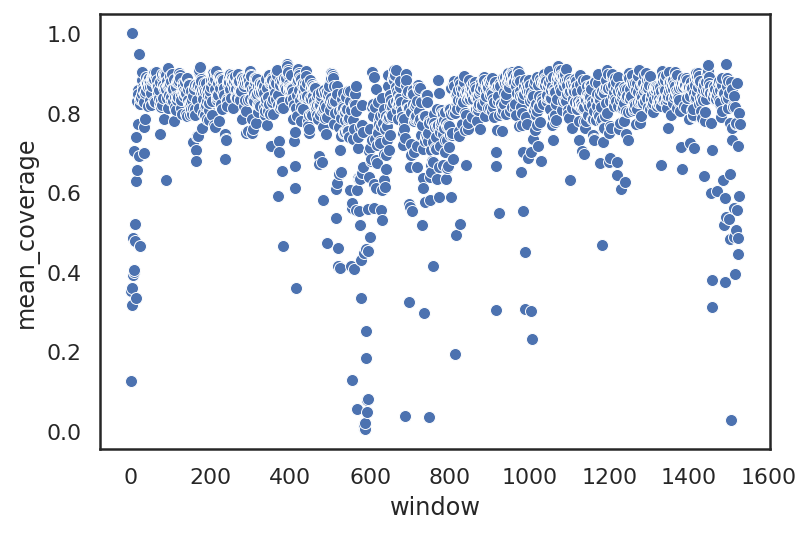

In [19]:
sns.scatterplot(data = mean_df_male, x = "window", y = "mean_coverage")

<AxesSubplot:xlabel='mean_het', ylabel='mean_coverage'>

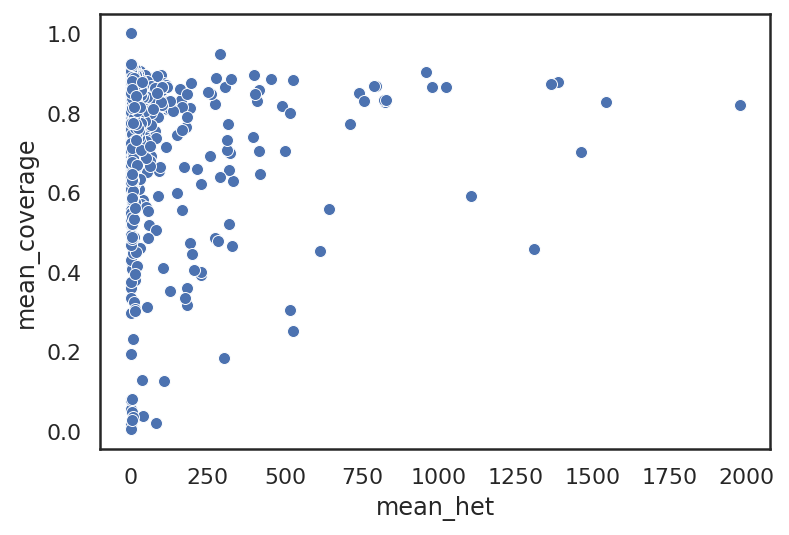

In [20]:
sns.scatterplot(data = mean_df_male, x = "mean_het", y = "mean_coverage")

In [21]:
#Female mean het and coverage on X
x_df = het_df_trimmed.loc[het_df_trimmed.chrom == "chrX"]
x_call = call_df_trimmed.loc[call_df_trimmed.chr == "chrX"]
x_df = x_df.loc[x_df.sex == "F"]
x_call = x_call.loc[x_call.sex == "F"]

het_list = []
coverage_list = []
window = []
max(x_df["start"])
for i in range(max(x_df["start"])):
    window.append(i)
    mean_het = x_df.loc[x_df.start == i]["het"].mean()
    het_list.append(mean_het)
    mean_coverage = x_call.loc[x_call.window == i]["coverage"].mean()
    coverage_list.append(mean_coverage)
d_female = {"window": window, "mean_het": het_list, "mean_coverage": coverage_list}
mean_df_female = pd.DataFrame(data = d_female)

<AxesSubplot:xlabel='window', ylabel='mean_het'>

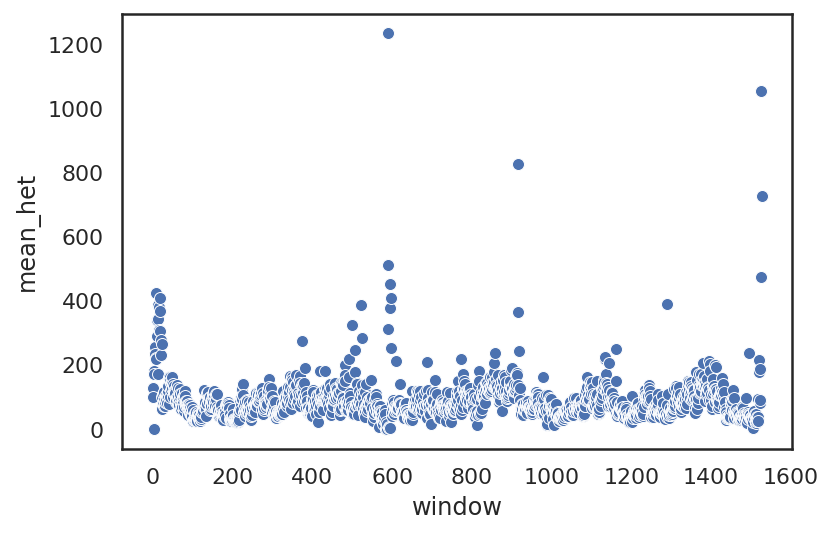

In [22]:
sns.scatterplot(data = mean_df_female, x = "window", y = "mean_het")

<AxesSubplot:xlabel='window', ylabel='mean_coverage'>

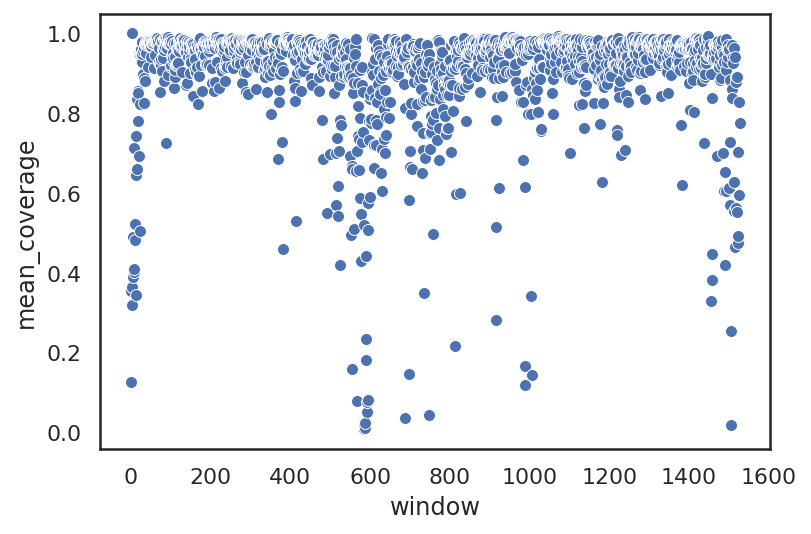

In [23]:
sns.scatterplot(data = mean_df_female, x = "window", y = "mean_coverage")

In [24]:
diff_het = mean_df_female["mean_het"]-mean_df_male["mean_het"]
diff_cov = mean_df_female["mean_coverage"]-mean_df_male["mean_coverage"]
data_diff = {"window": mean_df_male["window"], "diff_het": diff_het, "diff_cov": diff_cov}
diff_df = pd.DataFrame(data = data_diff)

<AxesSubplot:xlabel='window', ylabel='diff_het'>

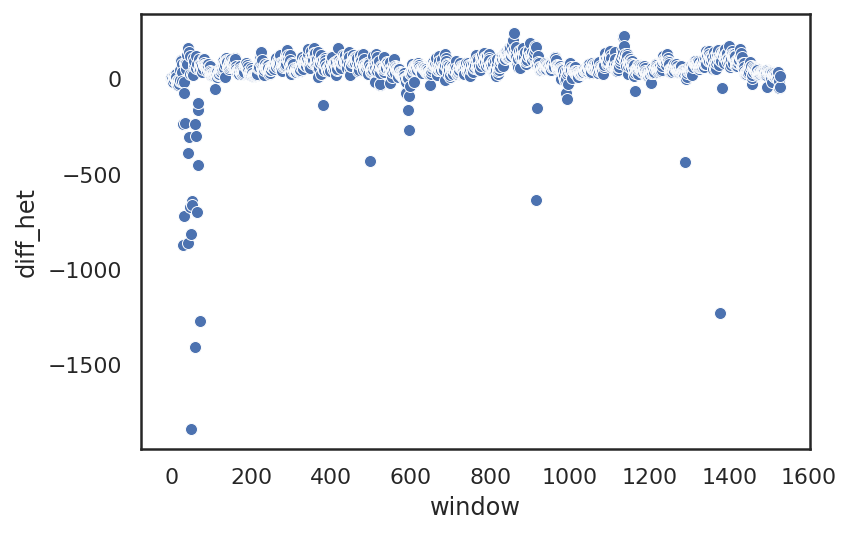

In [25]:
sns.scatterplot(data = diff_df, x = "window", y = "diff_het")

<AxesSubplot:xlabel='window', ylabel='diff_het'>

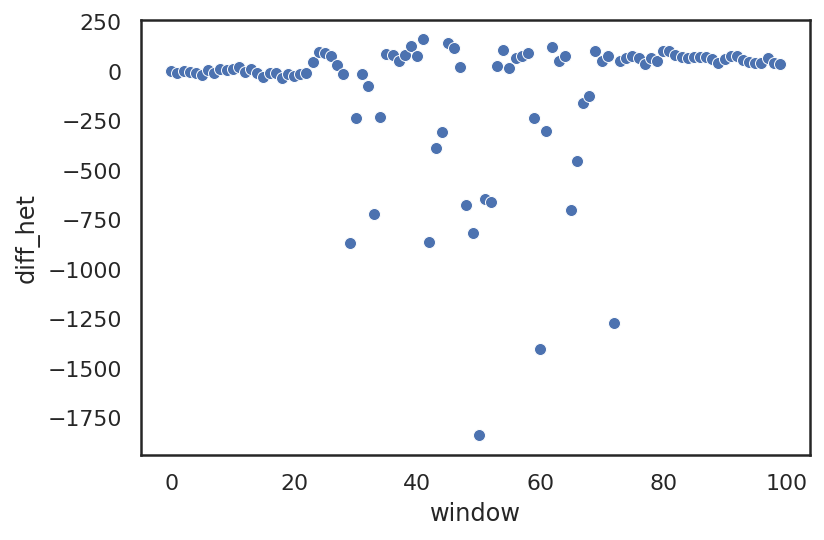

In [26]:
#Difference in het
sns.scatterplot(data = diff_df[:100], x = "window", y = "diff_het")

<AxesSubplot:xlabel='window', ylabel='diff_cov'>

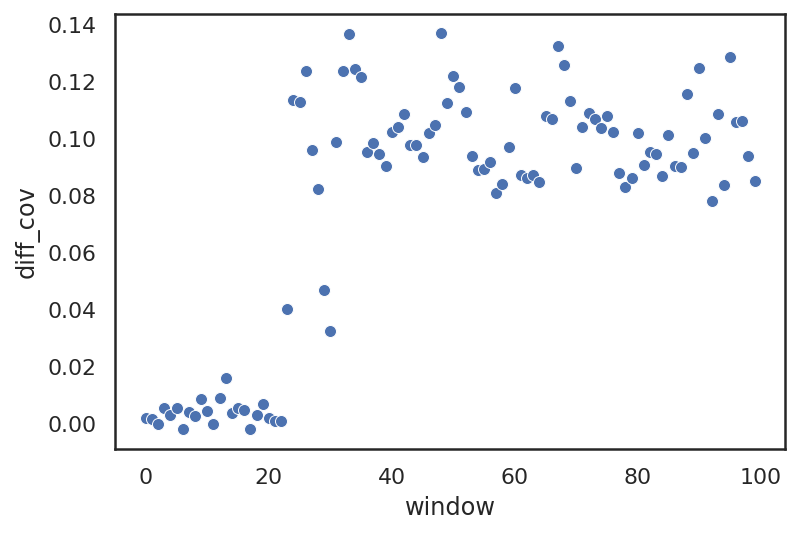

In [27]:
#Difference in coverage
sns.scatterplot(data = diff_df[:100], x = "window", y = "diff_cov")

<AxesSubplot:xlabel='window', ylabel='diff_het'>

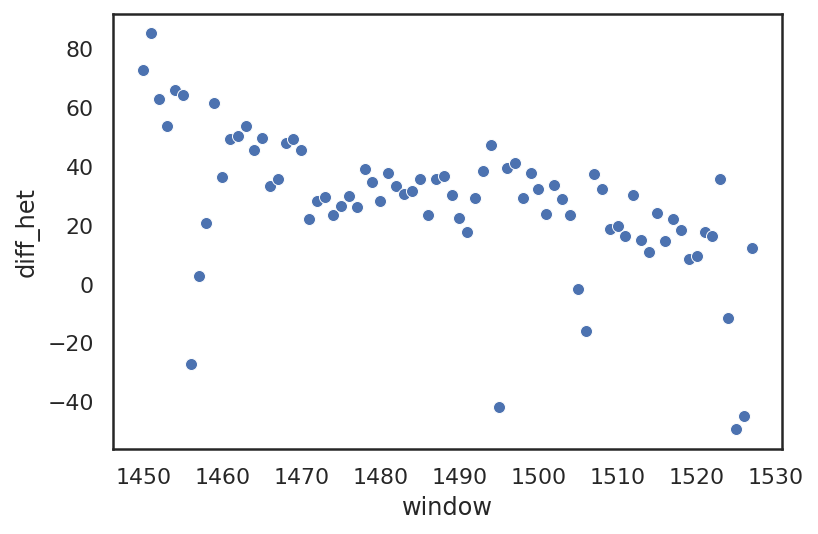

In [28]:
#Difference in het
sns.scatterplot(data = diff_df[1450:], x = "window", y = "diff_het")

<AxesSubplot:xlabel='window', ylabel='diff_cov'>

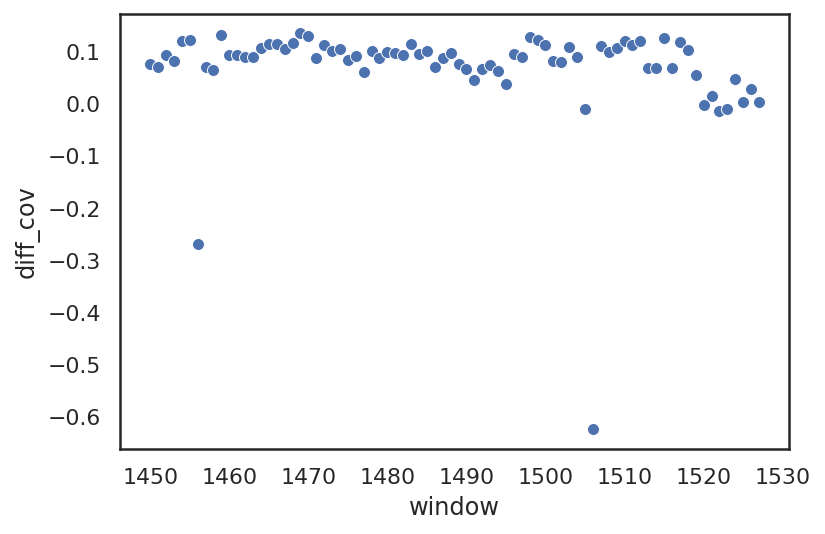

In [40]:
#Difference in coverage
sns.scatterplot(data = diff_df[1450:], x = "window", y = "diff_cov")

<AxesSubplot:xlabel='window', ylabel='diff_het'>

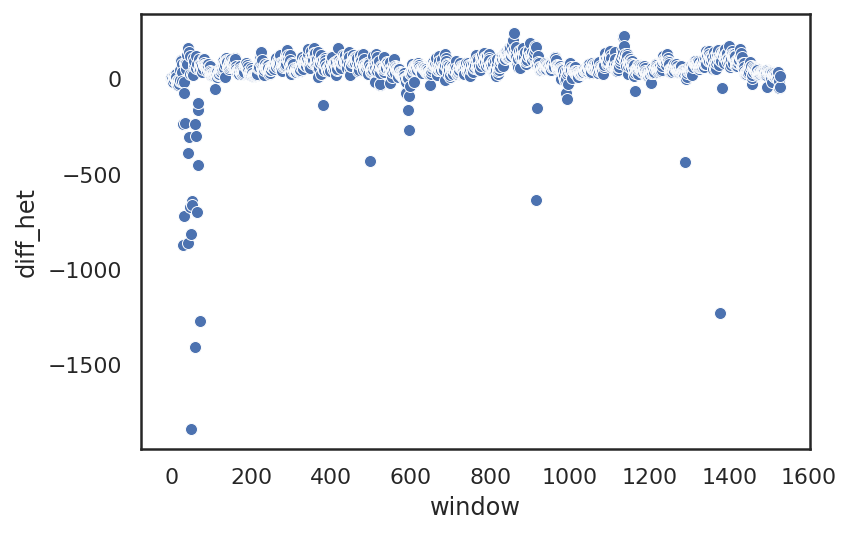

In [30]:
sns.scatterplot(data = diff_df, x = "window", y = "diff_het")

<AxesSubplot:xlabel='window', ylabel='diff_cov'>

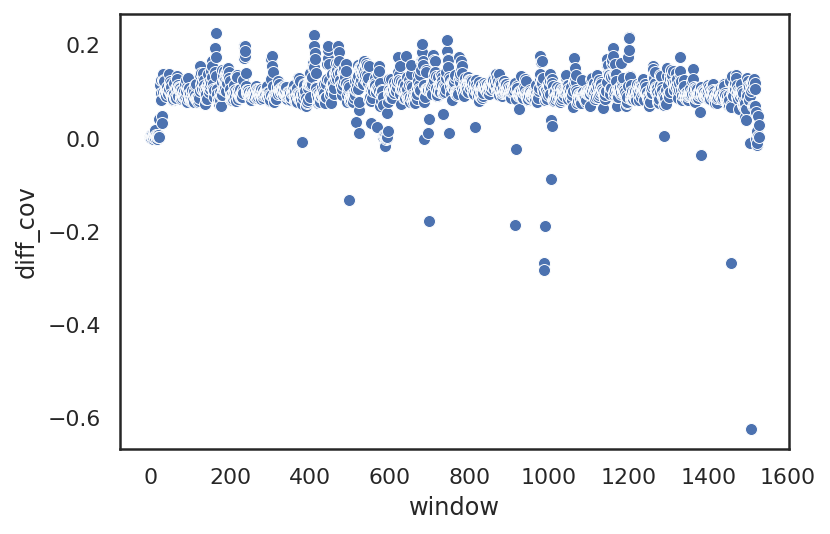

In [31]:
sns.scatterplot(data = diff_df, x = "window", y = "diff_cov")

In [32]:
#Doing a quick comparison with another chromosome
#Female mean het and coverage on 7
chr7_df = het_df_trimmed.loc[het_df_trimmed.chrom == "chr7"]
chr7_call = call_df_trimmed.loc[call_df_trimmed.chr == "chr7"]
chr7_df = chr7_df.loc[chr7_df.sex == "F"]
chr7_call = chr7_call.loc[chr7_call.sex == "F"]

het_list = []
coverage_list = []
window = []
max(x_df["start"])
for i in range(max(x_df["start"])):
    window.append(i)
    mean_het = x_df.loc[x_df.start == i]["het"].mean()
    het_list.append(mean_het)
    mean_coverage = x_call.loc[x_call.window == i]["coverage"].mean()
    coverage_list.append(mean_coverage)
chr7_d_female = {"window": window, "mean_het": het_list, "mean_coverage": coverage_list}
chr7_mean_df_female = pd.DataFrame(data = d_female)
#Male mean het and coverage on 7
chr7_df = het_df_trimmed.loc[het_df_trimmed.chrom == "chr7"]
chr7_call = call_df_trimmed.loc[call_df_trimmed.chr == "chr7"]
chr7_df = chr7_df.loc[chr7_df.sex == "M"]
chr7_call = chr7_call.loc[chr7_call.sex == "M"]

het_list = []
coverage_list = []
window = []
max(x_df["start"])
for i in range(max(x_df["start"])):
    window.append(i)
    mean_het = x_df.loc[x_df.start == i]["het"].mean()
    het_list.append(mean_het)
    mean_coverage = x_call.loc[x_call.window == i]["coverage"].mean()
    coverage_list.append(mean_coverage)
chr7_d_male = {"window": window, "mean_het": het_list, "mean_coverage": coverage_list}
chr7_mean_df_male = pd.DataFrame(data = d_male)
#Difference between the samples
diff_het = chr7_mean_df_female["mean_het"]-chr7_mean_df_male["mean_het"]
diff_cov = chr7_mean_df_female["mean_coverage"]-chr7_mean_df_male["mean_coverage"]
data_diff = {"window": mean_df_male["window"], "diff_het": diff_het, "diff_cov": diff_cov}
chr7_diff_df = pd.DataFrame(data = data_diff)

<AxesSubplot:xlabel='window', ylabel='diff_het'>

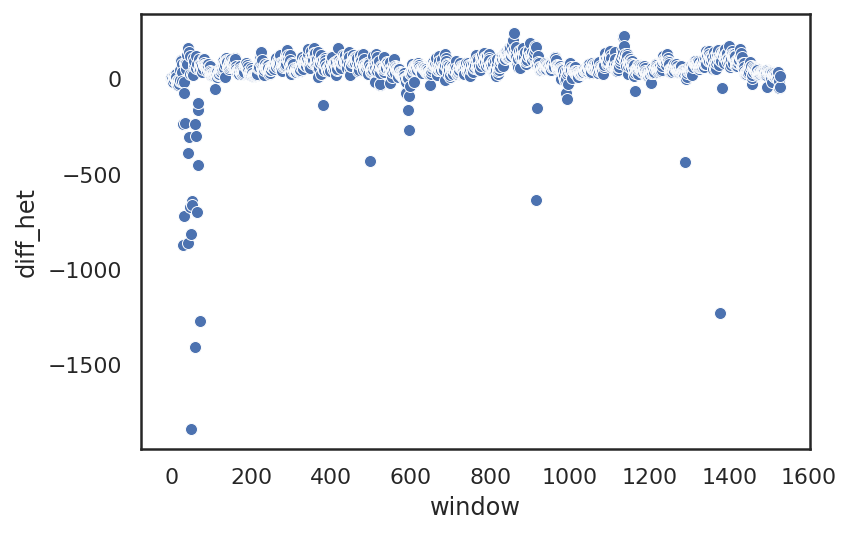

In [33]:
sns.scatterplot(data = chr7_diff_df, x = "window", y = "diff_het")

<AxesSubplot:xlabel='window', ylabel='diff_cov'>

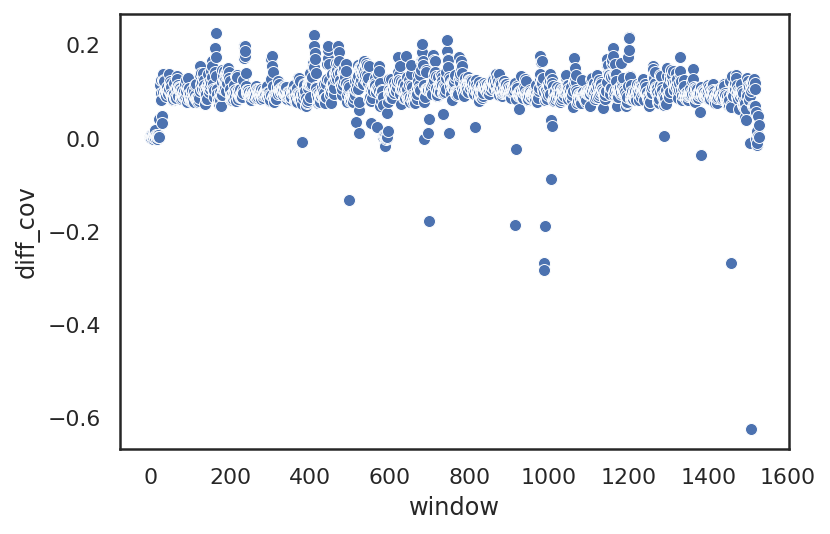

In [34]:
sns.scatterplot(data = chr7_diff_df, x = "window", y = "diff_cov")

In [35]:
#Subsetting to males and females
males = meta_data_samples.loc[meta_data_samples.Sex == "M"]["PGDP_ID"].to_list()
females = meta_data_samples.loc[meta_data_samples.Sex == "F"]["PGDP_ID"].to_list()
x_df = het_df_trimmed.loc[het_df_trimmed.chrom == "chrX"]
x_call = call_df_trimmed.loc[call_df_trimmed.chr == "chrX"]
x_males = x_df[x_df["pop"].isin(males)]
x_females = x_df[x_df["pop"].isin(females)]
chr7_males = chr7_df[chr7_df["pop"].isin(males)]
chr7_females = chr7_df[chr7_df["pop"].isin(females)]

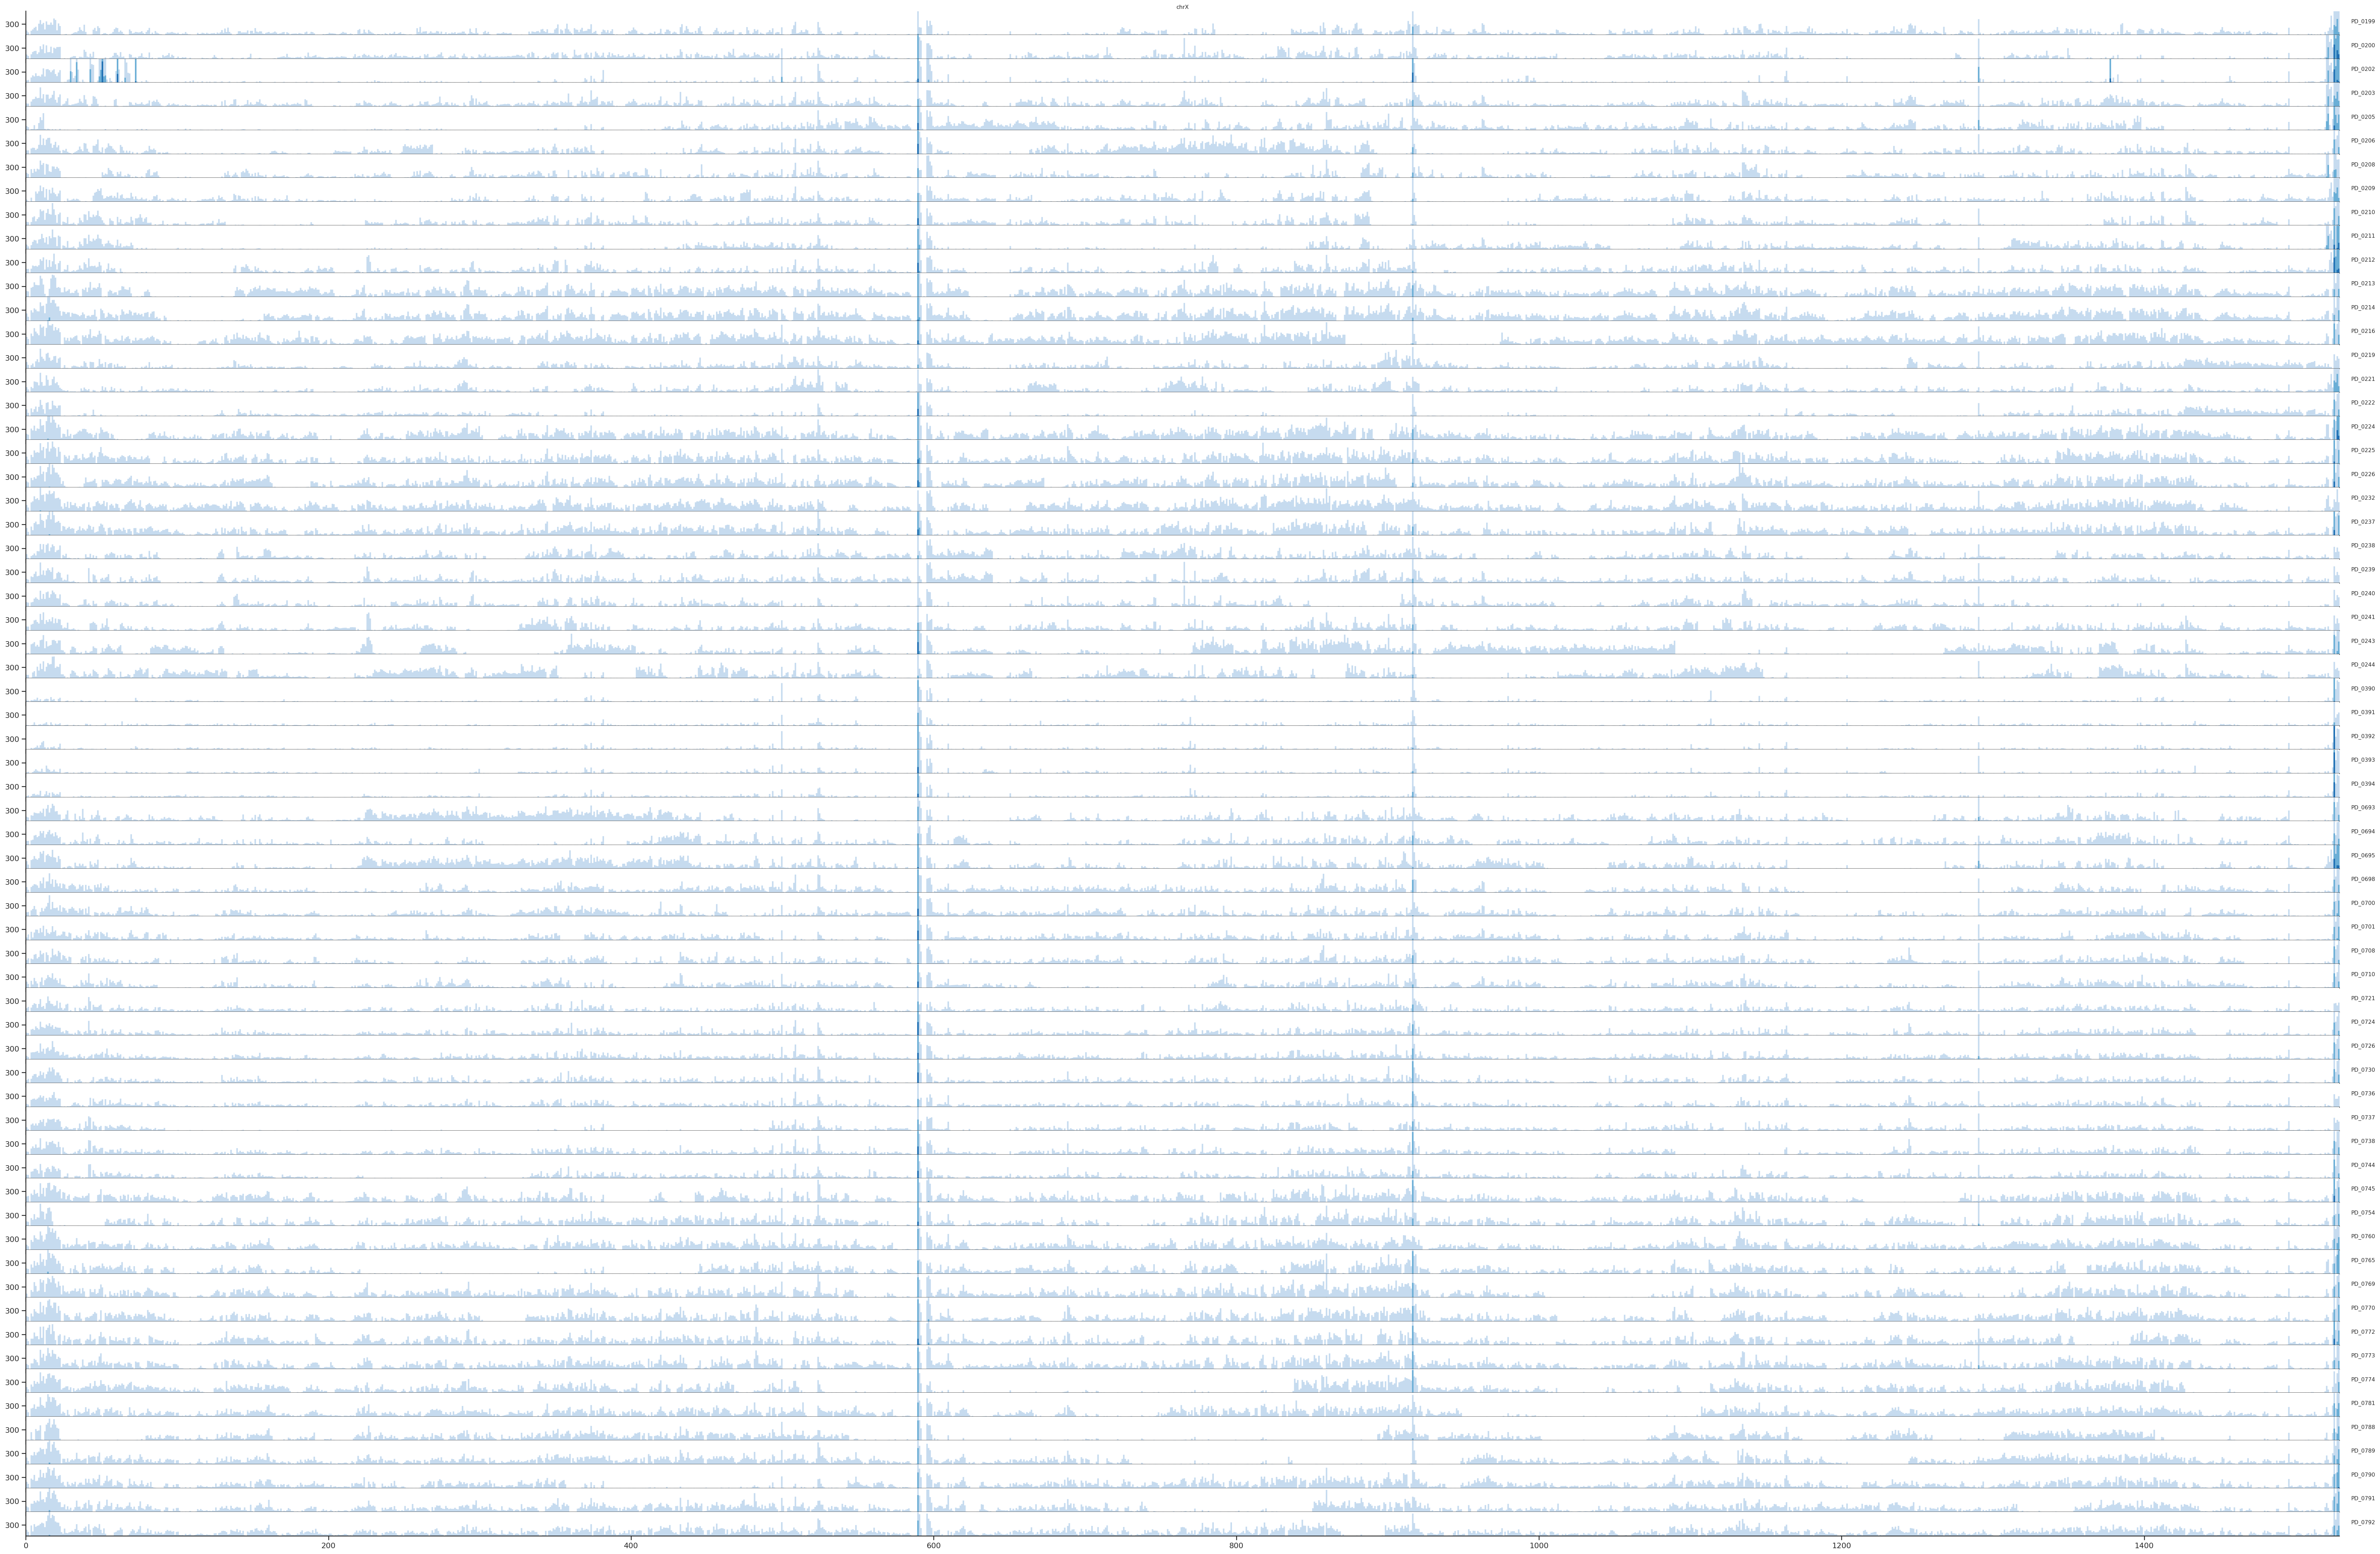

In [36]:
#All data shown
fig = horizonplot(x_females, 'het', width=1, col='chrom', row='pop', size=0.5, aspect=100)

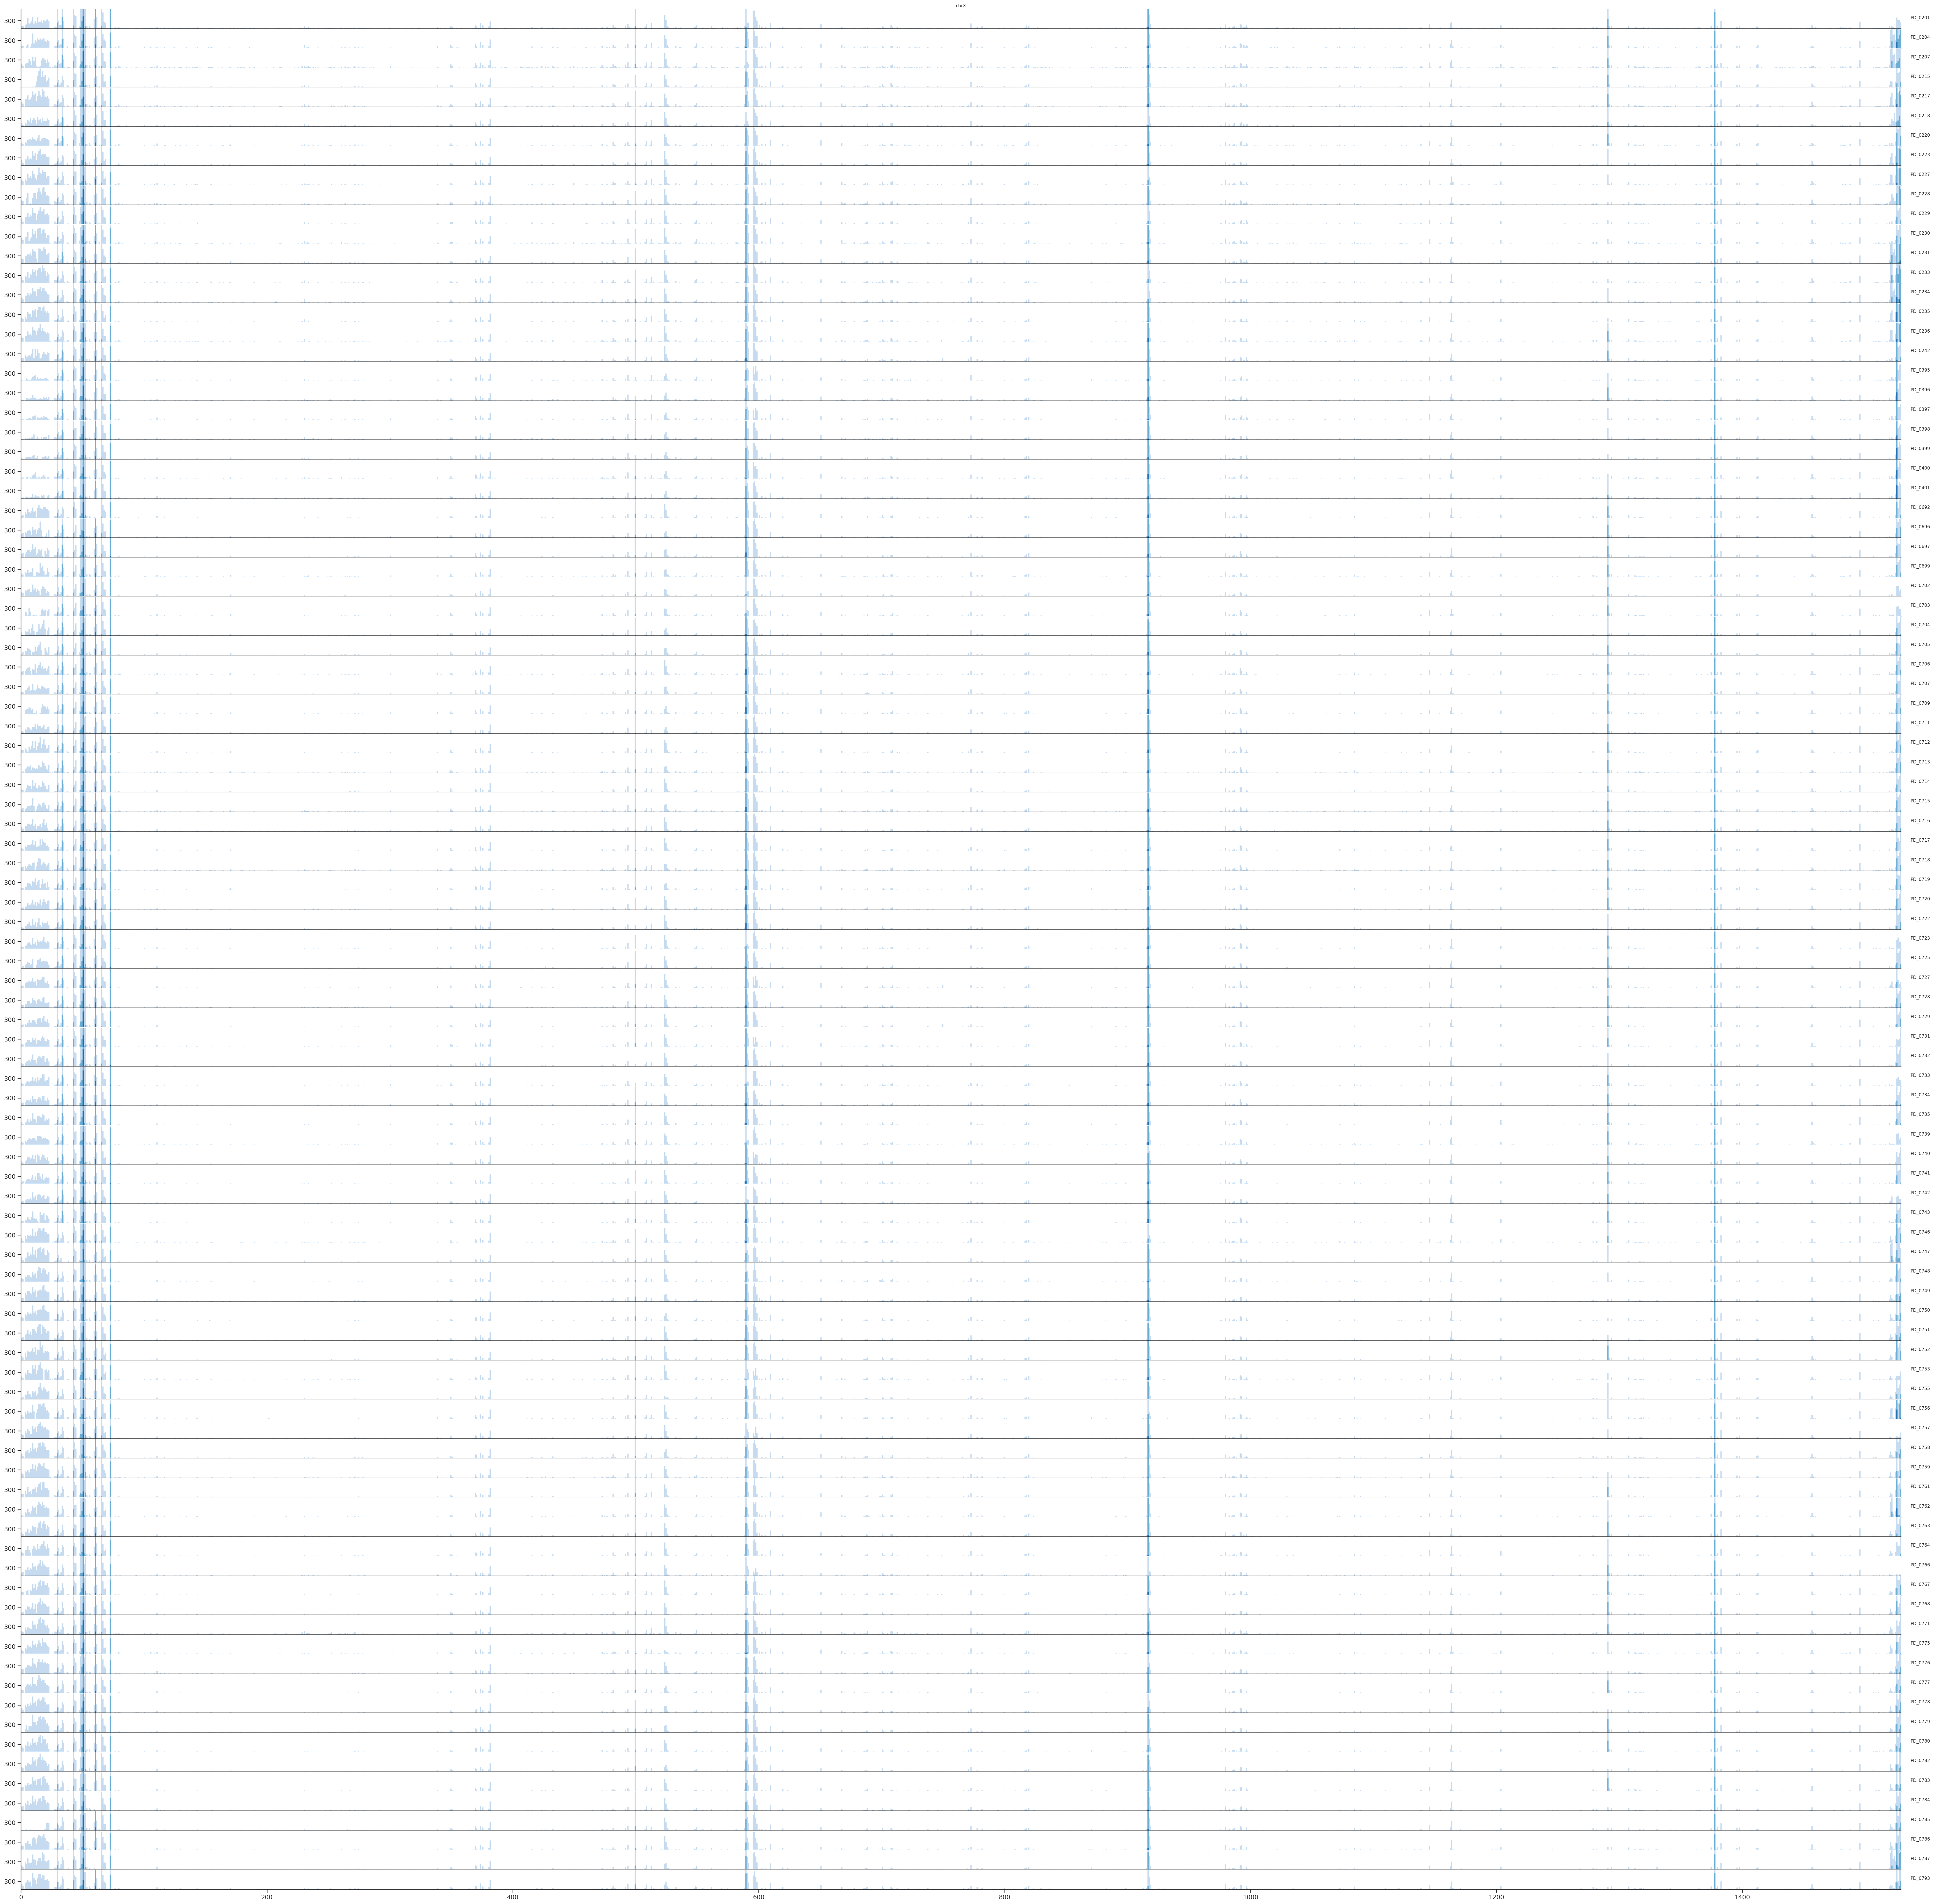

In [37]:
fig = horizonplot(x_males, 'het', width=1, col='chrom', row='pop', size=0.5, aspect=100)

In [38]:
fig = horizonplot(chr7_females, 'het', width=1, col='chrom', row='pop', size=0.5, aspect=100)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 0x0 with 0 Axes>

In [ ]:
fig = horizonplot(chr7_males, 'het', width=1, col='chrom', row='pop', size=0.5, aspect=100)

In [ ]:
#Subsetting to show the background heterozygosity better
sample_subset = meta_data_samples[1:9]
males = sample_subset.loc[sample_subset.Sex == "M"]["PGDP_ID"].to_list()
females = sample_subset.loc[sample_subset.Sex == "F"]["PGDP_ID"].to_list()
x_males = x_df[x_df["pop"].isin(males)]
x_females = x_df[x_df["pop"].isin(females)]
chr7_males = chr7_df[chr7_df["pop"].isin(males)]
chr7_females = chr7_df[chr7_df["pop"].isin(females)]

In [ ]:
#Plotting the subset individuals
fig = horizonplot(x_females,
                   'het', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 100)
fig = horizonplot(x_males,
                   'het', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 100)

In [ ]:
#Plotting subregion of the subset
fig = horizonplot(x_females.loc[(x_females.start <= 500) & (x_females.start >= 100)],
                   'het', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 50)
fig = horizonplot(x_males.loc[(x_males.start <= 500) & (x_males.start >= 100)],
                   'het', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 50)

In [ ]:
#The same plot, but using heterozygosity based on degree of callability
fig = horizonplot(x_females.loc[(x_females.start <= 500) & (x_females.start >= 100)],
                   'het_c', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 50)
fig = horizonplot(x_males.loc[(x_males.start <= 500) & (x_males.start >= 100)],
                   'het_c', width=1, col='chrom', row='pop', size=2, aspect=20, cut = 50)

In [ ]:
fig = horizonplot(x_males, 'het', width=1, col='chrom', row='pop', size=0.5, aspect=100)

In [ ]:
fig = horizonplot(chr7_females, 'het', width=1, col='chrom', row='pop', size=0.5, aspect=100)

In [ ]:
fig = horizonplot(chr7_males, 'het', width=1, col='chrom', row='pop', size=0.5, aspect=100)